<a href="https://colab.research.google.com/github/dreampulse/DefinitelyTyped/blob/master/cell_count_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image, ImageDraw, ImageFilter, ImageOps
from random import randint
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
! git clone https://github.com/dreampulse/cell-count-experiment.git

Cloning into 'cell-count-experiment'...
remote: Enumerating objects: 544, done.
remote: Total 544 (delta 0), reused 0 (delta 0), pack-reused 544
Receiving objects: 100% (544/544), 76.15 MiB | 40.03 MiB/s, done.
Resolving deltas: 100% (239/239), done.


In [3]:
!ls cell-count-experiment/cell-images

Cells1BackgroundMasked.png  Cells1Mask.png  Cells2.jpg	    Cells3.jpg
Cells1Masked.png	    Cells1.png	    Cells2Mask.png  Cells3Mask.png


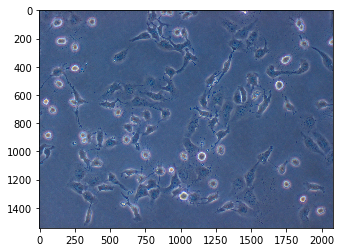

In [4]:
cells1 = Image.open("cell-count-experiment/cell-images/Cells1.png").convert('RGB')
cells2 = Image.open("cell-count-experiment/cell-images/Cells2.jpg").convert('RGB')
cells3 = Image.open("cell-count-experiment/cell-images/Cells3.jpg").convert('RGB')
imshow(cells2)

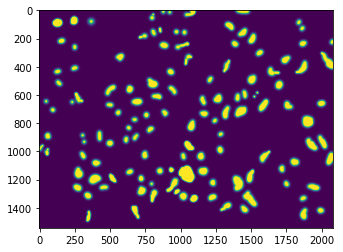

In [5]:
cells1_label = ImageOps.invert(Image.open("cell-count-experiment/cell-images/Cells1Mask.png").convert('L'))
cells2_label = ImageOps.invert(Image.open("cell-count-experiment/cell-images/Cells2Mask.png").convert('L'))
cells3_label = ImageOps.invert(Image.open("cell-count-experiment/cell-images/Cells3Mask.png").convert('L'))
imshow(cells2_label)

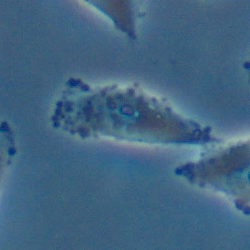

In [6]:
tiles_size = 250

def get_cropped_img(img, i, j, tiles_size = 250):
    return img.crop((i, j, i+tiles_size, j+tiles_size))

get_cropped_img(cells1, 150, 150)

0.8313725490196079


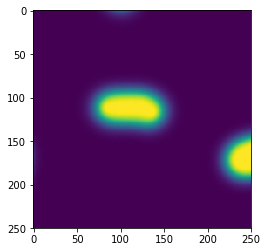

In [7]:
def get_cropped_label(img, i, j, tiles_size = 250):
  cropped_img = img.crop((i, j, i+tiles_size, j+tiles_size))
  cropped_label = np.array(cropped_img)
  center_pos = int(tiles_size/2)
  prob_cell_in_center = cropped_label[center_pos, center_pos] / 255.0
  return cropped_img, prob_cell_in_center, cropped_label

example_cropped_img, example_prob_cell_in_center, example_cropped_label = get_cropped_label(cells1_label, 150, 150)
imshow(example_cropped_img)
print(example_prob_cell_in_center)

In [8]:
def create_data(inputs):
  x_training = []
  y_training = []

  def append_data(img, label_img, step_size = 50):
    for j in range(0, img.height - tiles_size, step_size):
      for i in range(0, img.width - tiles_size, step_size):
        x_training.append(np.array(get_cropped_img(img, i, j)) / 255.0)
        y_training.append(np.array(get_cropped_label(label_img, i, j)[1]))

  for img, label_img in inputs:
     append_data(img, label_img)

  return np.array(x_training), keras.utils.to_categorical(np.where(np.array(np.array(y_training)) > .5, 1, 0), num_classes=2)

x_train, y_train = create_data([(cells1, cells1_label), (cells3, cells3_label)])
x_valid, y_valid = create_data([(cells2, cells2_label)])
print("Number of test images", len(x_train))
print("Number of validation images", len(x_valid))
# x_training[0]

Number of test images 1924
Number of validation images 962


In [0]:
label_height = int((cells2_label.height - tiles_size) / 50) + 1
label_width = int((cells2_label.width - tiles_size) / 50) + 1

In [19]:
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))


{0: 0.605412208936438, 1: 2.8716417910447762}

In [10]:
y_valid.transpose()[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0.

In [103]:
13*19*2

494

In [58]:
x_train.shape[1:]

(250, 250, 3)

In [11]:
num_classes = 2

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)), 
    keras.layers.Dropout(0.5),    
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 250, 250, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 248, 248, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 124, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 984064)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               125960320 


In [12]:
model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer='sgd',
              # optimizer='adam',
              optimizer=keras.optimizers.Adadelta(),
              metrics=["accuracy"])

In [20]:
history = model.fit(x_train, y_train, epochs=3, validation_data=(x_valid, y_valid), shuffle=True, class_weight=d_class_weights)

Train on 1924 samples, validate on 962 samples
Epoch 1/3
1924/1924 [==============================] - 36s 19ms/step - loss: 8.0590 - acc: 0.8259 - val_loss: 1.5079 - val_acc: 0.9064
Epoch 2/3
1924/1924 [==============================] - 36s 19ms/step - loss: 8.0590 - acc: 0.8259 - val_loss: 1.5079 - val_acc: 0.9064
Epoch 3/3
1924/1924 [==============================] - 36s 18ms/step - loss: 8.0590 - acc: 0.8259 - val_loss: 1.5079 - val_acc: 0.9064


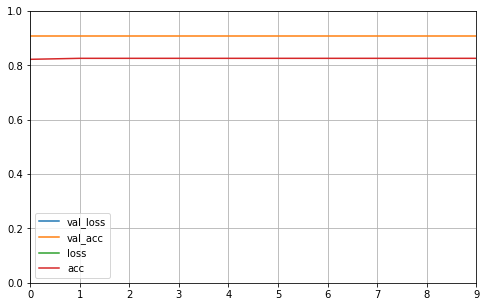

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()


In [44]:
argmax(model.predict(x_valid), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

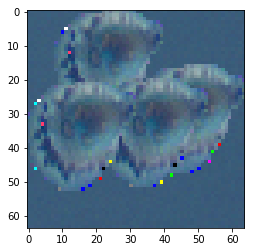

In [0]:
# Das hier ist ein Trainingsbild
x_org = x_valid[0]*255
imshow(Image.fromarray(x_org.astype(np.uint8)))

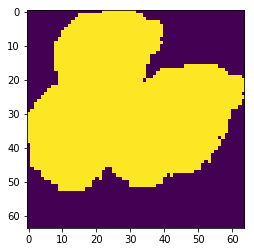

In [0]:
# Das hier sind die Labels die trainiert wurden
y_org = y_valid[0]*255
imshow(Image.fromarray(y_org.astype(np.uint8)))

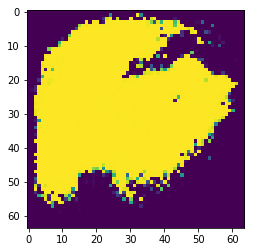

In [0]:
# Das hier hat das netzt predicted
y_pred = model.predict(np.array([x_valid[0]]))*255
imshow(Image.fromarray(y_pred[0].astype(np.uint8)))

In [0]:
mse = ((y_valid[0] - model.predict(np.array([x_valid[0]])))**2).mean(axis=None)
print(mse)

0.1277631149422601


In [15]:
keras.utils.to_categorical([0, 1, 0.2, 0.8], num_classes=2)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [17]:
np.where(np.array([0, 1, 0.2, 0.8]) > .5, 1, 0)

array([0, 1, 0, 1])

In [25]:
np.array([np.array([1,2,3])])

array([[1, 2, 3]])

In [35]:
from numpy.random import randint
from numpy import argmax
from keras.utils.np_utils import to_categorical
k = 8
n = 20
x = randint(0, k, (n,))
print(x)
print(argmax(to_categorical(x, k)))
print(argmax([to_categorical(x, k)], axis=1))

[4 1 1 2 3 7 5 2 2 0 1 5 3 3 6 0 5 6 2 5]
4
[4 1 1 2 3 7 5 2 2 0 1 5 3 3 6 0 5 6 2 5]


In [43]:
argmax([[0,1,0], [0,0,1]], axis=1)

array([1, 2])